# [In Progress] Bollinger Bands Scaling Strategy (BBSS)

In This notebook, I am applying a custom BB Strategy, where I am going to scale the current Close value with respect to upper and lower bollinger bands

$
Close_{scaled} = \frac{Close - BB_{Lower}}{BB_{Upper} - BB_{Lower}}\
\implies
Close_{scaled} \in [0, 1]
$

Once this is done, I will map points in the scaling region where buy and sell signals need to be mapped. If there are clear disinctions in the BB regions of Buy and Sell, then I will try Hypothesis testing of the same concept.

Additionally, I will try to identify BB width ranges as well to identify the correct aspects of signals

In [45]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import talib
from tqdm import tqdm


def load(file_):
    try:
        _df = pd.read_csv(file_, parse_dates=True)
        _df.datetime = pd.to_datetime(_df.datetime)
        _df['date'] = _df.datetime.dt.date
        _df.set_index('datetime', inplace=True)
        return _df
    except Exception as e:
        return pd.DataFrame()

def expected_options_pnl(points, delta=.6, lots=10, lot_size=50):
    return points * delta * lots * lot_size


file_df = pd.DataFrame([
    {
        'stock_code': file_.split('/')[-2],
        'path': file_,
    } for file_ in glob('/workspace/nifty/NIFTY/202*.csv')
    # if 'options_history' not in file_ and 'OPTIONS' not in file_ and 'CALL' not in file_ and 'PUT' not in file_
])

df_map = {}

# expected_options_pnl(5)

for stock, group in tqdm(file_df.groupby('stock_code')):
    df_map[stock] = pd.concat(
        list(
            map(
                load,
                sorted(group.path.tolist())
            )
        )
    ).sort_index()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


In [35]:
nifty_df = df_map[stock][['open', 'high', 'low', 'close']].copy()

nifty_df

,open,high,low,close
datetime,,,,
2020-01-01 09:07:00,12202.15,12202.15,12202.15,12202.15
2020-01-01 09:15:00,12201.55,12216.25,12201.55,12215.45
2020-01-01 09:16:00,12214.55,12216.45,12205.70,12206.50
2020-01-01 09:17:00,12205.85,12207.40,12202.70,12203.55
2020-01-01 09:18:00,12202.15,12208.40,12201.20,12208.35
...,...,...,...,...
2024-05-13 15:25:00,22124.90,22127.30,22122.30,22125.90
2024-05-13 15:26:00,22125.05,22127.30,22123.80,22126.25
2024-05-13 15:27:00,22126.80,22131.05,22126.10,22129.85


In [ ]:

def mark_events(data, ref_frame=5):
    data = data.copy()
    data['sell'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).max()).astype(int)
    data['buy'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).min()).astype(int)
    data['hold'] = data.apply(lambda row: int(
        not (row['sell'] or row['buy'])), axis=1)
    return data


In [153]:
import talib
groups = []

N = 5
for _, group in tqdm(nifty_df.groupby(nifty_df.index.date)):
    group = mark_events(group,4)
    group['bb_ub'], group['bb_mb'], group['bb_lb'] = talib.BBANDS(group.close)
    group['bb_width'] = group['bb_ub'] - group['bb_mb']
    
    # group['delta_n'] = group.close.shift(-N) - group.close
    groups.append(group)


groups_df = pd.concat(groups)
groups_df['scaled_close'] = ((groups_df.close - groups_df.bb_lb)/(groups_df.bb_ub - groups_df.bb_lb)).clip(0, 1)
groups_df['bb_width_qcut'] = pd.qcut(groups_df.bb_width, 20)
groups_df['scaled_close_qcut'] = pd.qcut(groups_df.scaled_close, 20)

groups_df.index = pd.to_datetime(groups_df.index)
# lt, ut = groups_df.delta_n.quantile([.25, .75]).values
# print(lt, ut)
# groups_df['buy_signal'] = groups_df['delta_n'] >= ut
# groups_df['sell_signal'] = groups_df['delta_n'] <= lt

print(groups_df[['buy', 'sell', 'hold']].value_counts(normalize=True))
print(groups_df[['buy', 'sell', 'hold']].value_counts())

groups_df.dropna()
# .head(20)

# pd.concat([ for _, group in ])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1078/1078 [00:04<00:00, 260.79it/s]


buy  sell  hold
0    0     1       0.826660
1    0     0       0.087041
0    1     0       0.086045
1    1     0       0.000255
Name: proportion, dtype: float64
buy  sell  hold
0    0     1       334499
1    0     0        35220
0    1     0        34817
1    1     0          103
Name: count, dtype: int64


,open,high,low,close,sell,buy,hold,bb_ub,bb_mb,bb_lb,bb_width,scaled_close,bb_width_qcut,scaled_close_qcut
datetime,,,,,,,,,,,,,,
2020-01-01 09:18:00,12202.15,12208.40,12201.20,12208.35,0,0,1,12216.525235,12207.20,12197.874765,9.325235,0.561661,"(8.791, 9.646]","(0.511, 0.57]"
2020-01-01 09:19:00,12208.50,12213.20,12207.70,12211.30,0,0,1,12217.191519,12209.03,12200.868481,8.161519,0.639067,"(8.046, 8.791]","(0.626, 0.677]"
2020-01-01 09:20:00,12211.85,12212.75,12210.00,12211.35,0,0,1,12214.147474,12208.21,12202.272526,5.937474,0.764422,"(5.744, 6.252]","(0.723, 0.766]"
2020-01-01 09:21:00,12211.70,12212.00,12208.80,12210.05,0,0,1,12214.717103,12208.92,12203.122897,5.797103,0.597462,"(5.744, 6.252]","(0.57, 0.626]"
2020-01-01 09:22:00,12210.65,12213.70,12209.85,12213.10,0,0,1,12213.979984,12210.83,12207.680016,3.149984,0.860319,"(2.852, 3.39]","(0.845, 0.885]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-13 15:25:00,22124.90,22127.30,22122.30,22125.90,0,0,1,22128.571908,22121.68,22114.788092,6.891908,0.806156,"(6.8, 7.388]","(0.806, 0.845]"
2024-05-13 15:26:00,22125.05,22127.30,22123.80,22126.25,0,0,1,22129.046519,22123.59,22118.133481,5.456519,0.743745,"(5.269, 5.744]","(0.723, 0.766]"
2024-05-13 15:27:00,22126.80,22131.05,22126.10,22129.85,0,0,1,22130.667458,22125.79,22120.912542,4.877458,0.916200,"(4.808, 5.269]","(0.885, 0.931]"


/tmp/ipykernel_4153777/4243637136.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (cut, group) in enumerate(groups_df.groupby(['bb_width_qcut', ])):


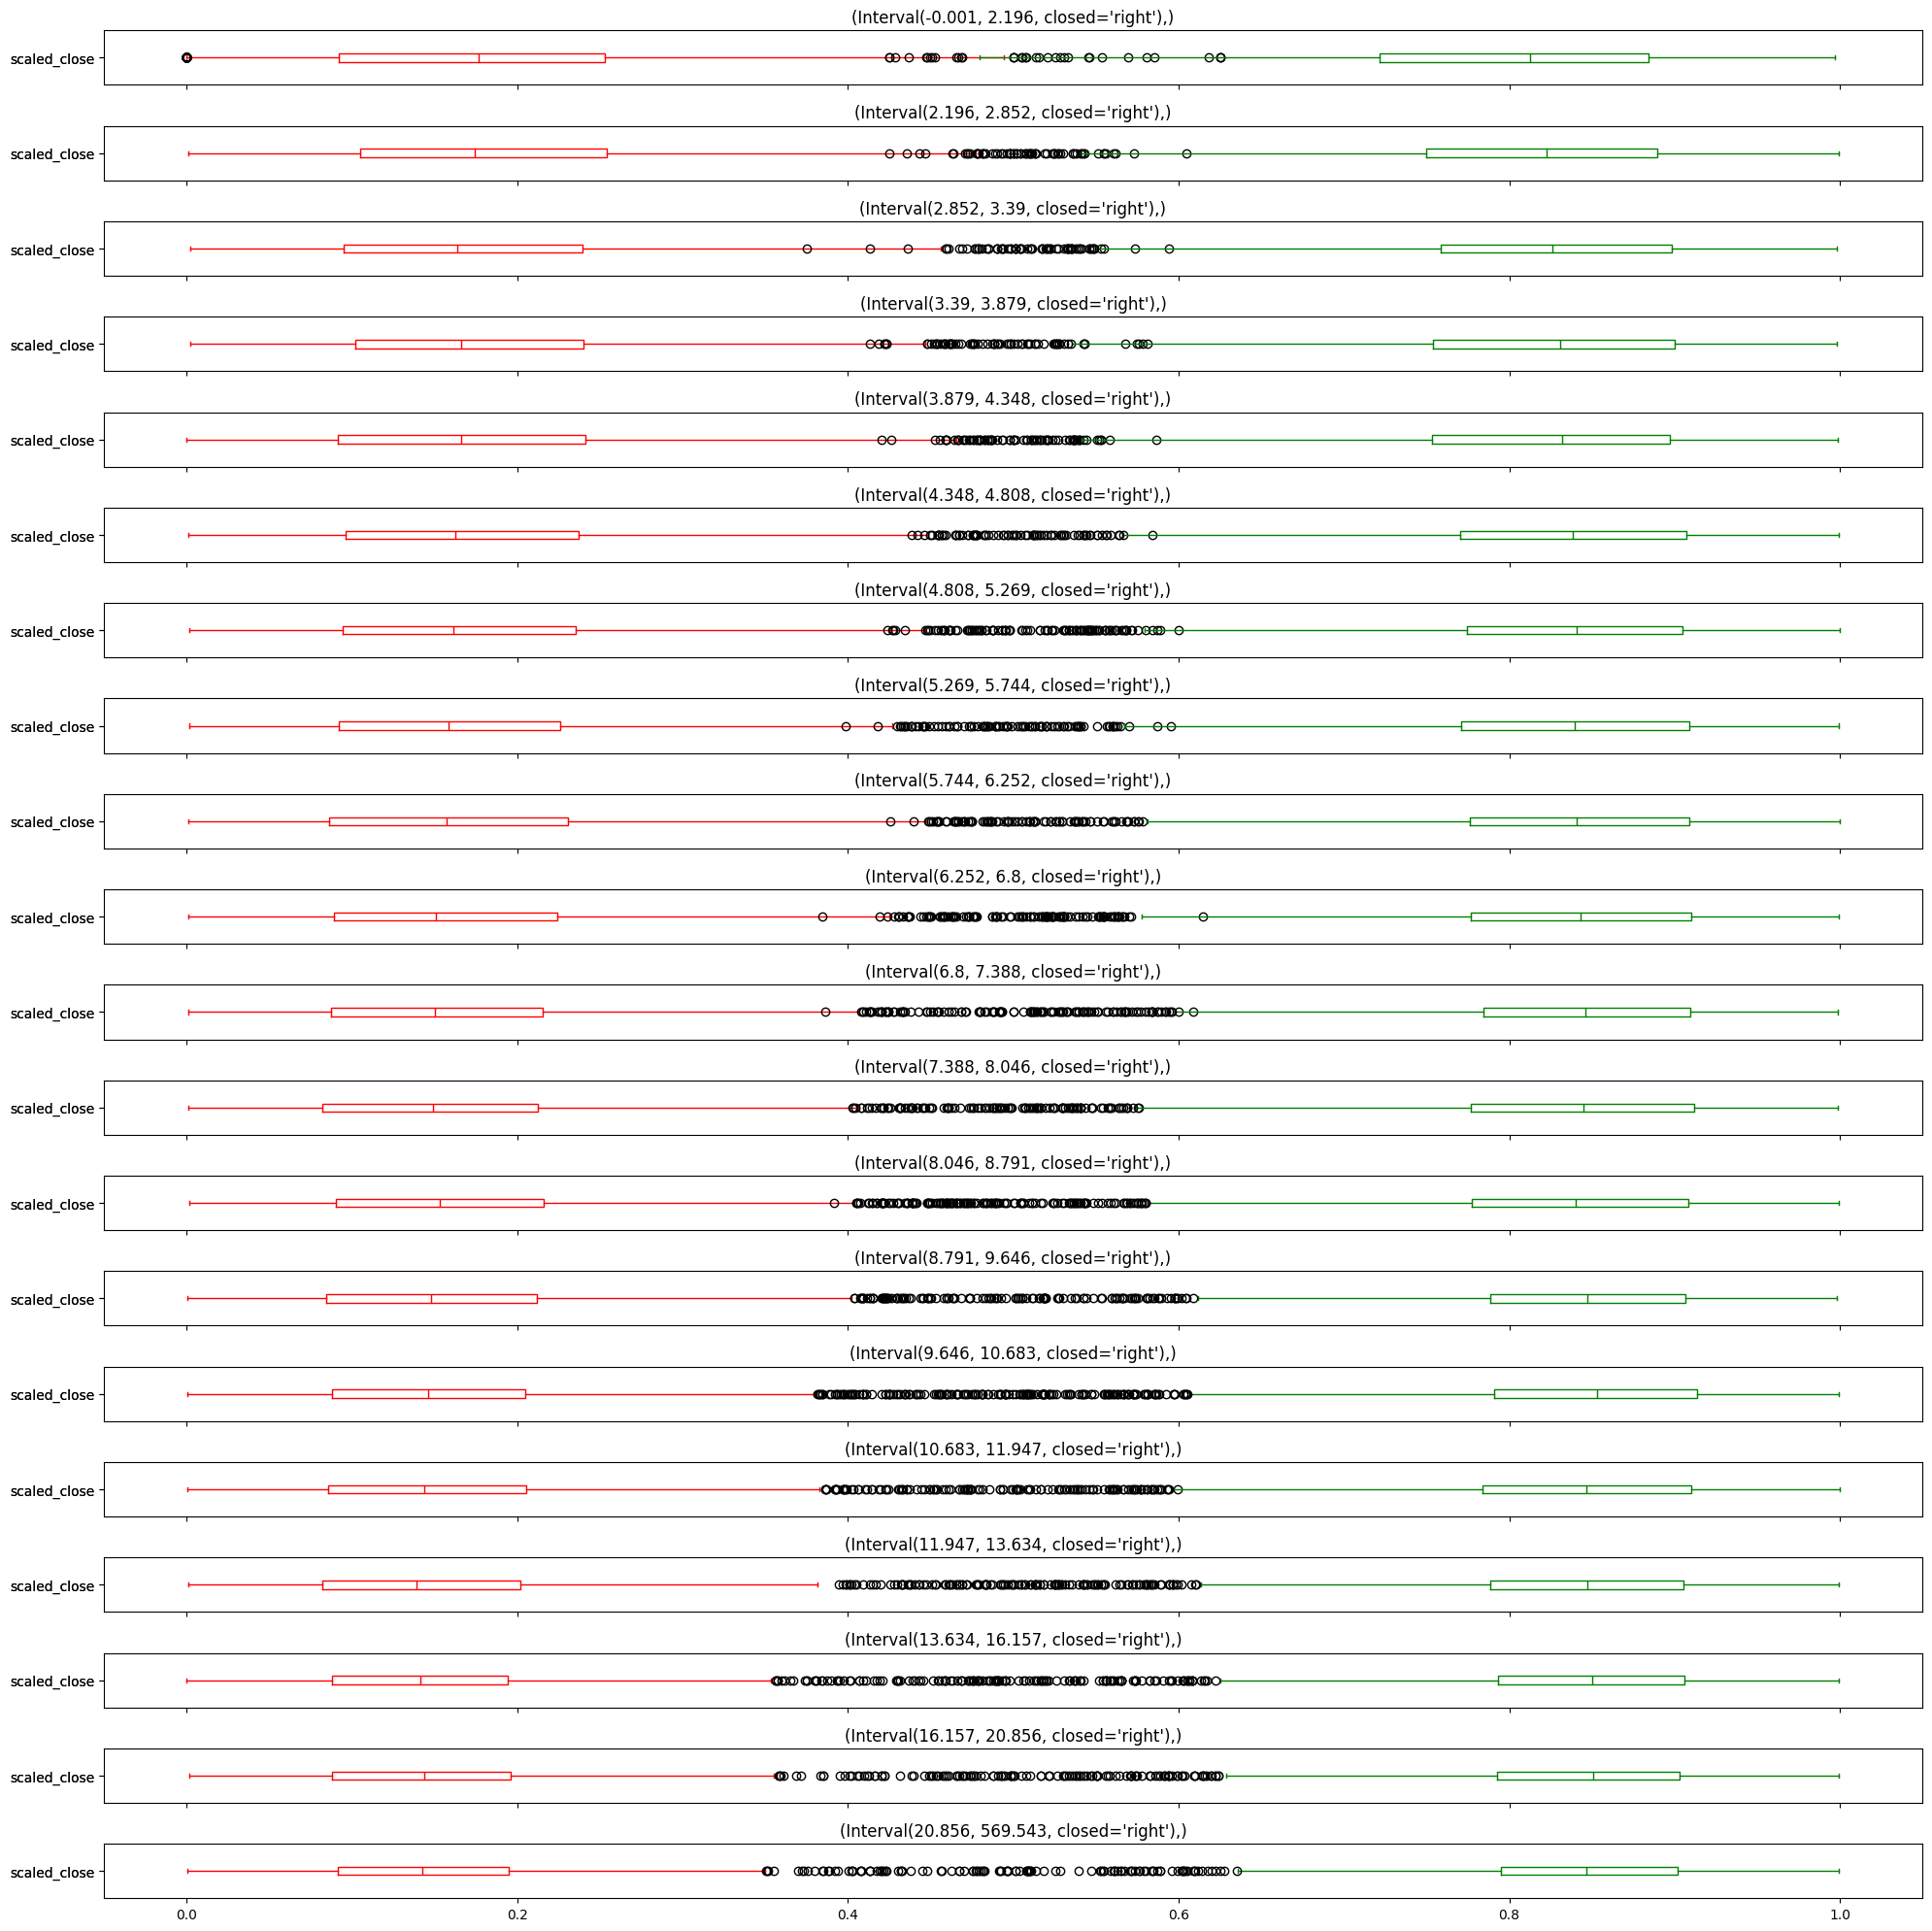

In [165]:
fig, ax = plt.subplots(20, 1, figsize=(20, 20), sharex=True)

bb_cut_map = {}
for i, (cut, group) in enumerate(groups_df.groupby(['bb_width_qcut', ])):
    group[group['buy']==1].scaled_close.plot.box(vert=False, ax=ax[i], color='red')
    group[group['sell']==1].scaled_close.plot.box(vert=False, ax=ax[i], color='green')
    bb_cut_map[(cut, 'buy')] = group[group['buy']==1].scaled_close.quantile(.75)
    bb_cut_map[(cut, 'sell')] = group[group['sell']==1].scaled_close.quantile(.25)
    ax[i].set_title(cut)

plt.tight_layout()
plt.show()
    
# .quantile([.05, .25, .5, .75, .95])

In [213]:
# gdf = 

cut_groups = []

for (bb_cut, close_cut), group in groups_df.groupby(['bb_width_qcut', 'scaled_close_qcut',]):
    g = pd.DataFrame(group.buy.value_counts(normalize=True)).reset_index()
    g[['bb_cut', 'close_cut']] = bb_cut, close_cut
    cut_groups.append(g)


gdf = pd.concat(cut_groups)
gdf[gdf['buy']==1].head()

/tmp/ipykernel_4153777/3516591181.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (bb_cut, close_cut), group in groups_df.groupby(['bb_width_qcut', 'scaled_close_qcut',]):


,buy,proportion,bb_cut,close_cut
1,1,0.329560,"(-0.001, 2.196]","(-0.001, 0.0662]"
1,1,0.282577,"(-0.001, 2.196]","(0.0662, 0.111]"
1,1,0.263380,"(-0.001, 2.196]","(0.111, 0.153]"
1,1,0.267516,"(-0.001, 2.196]","(0.153, 0.193]"
1,1,0.248613,"(-0.001, 2.196]","(0.193, 0.237]"


In [214]:
import numpy as np

def map_threshold(row):
    row['threshold']=np.nan
    if row['buy']==1:
        row['threshold'] = bb_cut_map.get(((row['bb_cut'],), 'buy'))
        # print(((row['bb_cut'],), 'buy'))
    # if row['sell']==1:
    #     row['threshold'] = bb_cut_map[(row['bb_cut'], 'sell')]
    return row

gdf = gdf.apply(lambda x: map_threshold(x), axis=1).dropna()
gdf['ranged'] = gdf[:].apply(lambda x:  x['close_cut'].left<=x['threshold']<= x['close_cut'].right, axis=1)
# .value_counts()
# gdf.apply(lambda x: x['threshold'] in x['close_cut'], axis=1)
gdf[gdf['ranged']]
# [(gdf['buy']==1) & (gdf['proportion']>.30)].sort_values('bb_cut', ascending=False)


# gdf[gdf['buy']==1]['proportion'].quantile([.05, .25, .50, .75, .95])

,buy,proportion,bb_cut,close_cut,threshold,ranged
1,1,0.162402,"(-0.001, 2.196]","(0.237, 0.284]",0.253092,True
1,1,0.141879,"(2.196, 2.852]","(0.237, 0.284]",0.253929,True
1,1,0.148744,"(2.852, 3.39]","(0.237, 0.284]",0.239585,True
1,1,0.155224,"(3.39, 3.879]","(0.237, 0.284]",0.239953,True
1,1,0.160000,"(3.879, 4.348]","(0.237, 0.284]",0.241459,True
1,1,0.154497,"(4.348, 4.808]","(0.237, 0.284]",0.237287,True
1,1,0.271751,"(4.808, 5.269]","(0.193, 0.237]",0.235666,True
1,1,0.259299,"(5.269, 5.744]","(0.193, 0.237]",0.226189,True
1,1,0.228448,"(5.744, 6.252]","(0.193, 0.237]",0.230960,True
1,1,0.238342,"(6.252, 6.8]","(0.193, 0.237]",0.224206,True


In [ ]:
from backtesting import Strategy, Backtest

class BBIdeal(Strategy):
    def _is_trading_window(self):
        if self.data.index[-1].hour >= 15 or self.data.index[-1].hour <= 9:
            return False
        return True

    def init(self):
        pass
    def next(self):
        if not self._is_trading_window():
            self.position.close()
            return

        for trade in self.trades:
            if trade.pl>=6:
                trade.close()
            if trade.pl<=-6:
                trade.close()
        
        if self.data.buy[-1]==1:
            self.buy(size=1)
        
        if self.data.sell[-1]==1:
            self.sell(size=1)


run = Backtest(
    groups_df[
        (groups_df.index.year==2024) 
        # & (groups_df.index.month==4)
    ].rename(
        columns={
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
        }
    ),
    BBIdeal,
    cash=1e6,
    commission=.0,
)

stats = run.run()
import humanize
print(humanize.intword(expected_options_pnl(stats['Equity Final [$]']-1e6)))
stats

In [110]:
from backtesting import Strategy, Backtest

class BBIdeal(Strategy):
    def _is_trading_window(self):
        if self.data.index[-1].hour >= 15 or self.data.index[-1].hour <= 9:
            return False
        return True

    def init(self):
        pass
    def next(self):
        if not self._is_trading_window():
            self.position.close()
            return

        for trade in self.trades:
            if trade.pl>=6:
                trade.close()
            if trade.pl<=-6:
                trade.close()
        
        if self.data.buy[-1]==1:
            self.buy(size=1)
        
        if self.data.sell[-1]==1:
            self.sell(size=1)


run = Backtest(
    groups_df[
        (groups_df.index.year==2024) 
        # & (groups_df.index.month==4)
    ].rename(
        columns={
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
        }
    ),
    BBIdeal,
    cash=1e6,
    commission=.0,
)

stats = run.run()
import humanize
print(humanize.intword(expected_options_pnl(stats['Equity Final [$]']-1e6)))
stats

12.8 million


/workspace/learning_by_failure/.venv/lib/python3.11/site-packages/backtesting/_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Start                     2024-01-01 09:07:00
End                       2024-05-13 15:29:00
Duration                    133 days 06:22:00
Exposure Time [%]                   41.655651
Equity Final [$]                    1042590.0
Equity Peak [$]                    1042590.25
Return [%]                              4.259
Buy & Hold Return [%]                1.802534
Return (Ann.) [%]                   12.285794
Volatility (Ann.) [%]                0.182127
Sharpe Ratio                        67.457136
Sortino Ratio                             inf
Calmar Ratio                      1948.418074
Max. Drawdown [%]                   -0.006306
Avg. Drawdown [%]                   -0.000131
Max. Drawdown Duration        3 days 19:19:00
Avg. Drawdown Duration        0 days 00:41:00
# Trades                                 4653
Win Rate [%]                        97.464002
Best Trade [%]                       0.283219
Worst Trade [%]                     -0.112162
Avg. Trade [%]                    

In [2]:
from backtesting import Strategy
from typing import Tuple
from backtester import simulate

Signal = Tuple[bool, bool, bool]


def mark_action(data, positions, trades, closed_trades):
    buy, close_pos, sell = False, False, False
    if data.strategy_buy and (not positions.size or positions.is_short):
        buy = True
        close_pos = True
    elif data.strategy_sell and (not positions.size or positions.is_long):
        sell = True
        close_pos = True
    return buy, close_pos, sell


class BBStrategy(Strategy):
    signal = None
    SL = 5
    TP = 10

    def _is_trading_window(self):
        if (
            self.data.index[-1].hour == 15 and
            self.data.index[-1].minute > 15
        ) or (
            self.data.index[-1].hour == 9 and
            self.data.index[-1].minute < 30
        ):
            return False
        return True

    def __init__(self, broker, data, params):
        super().__init__(broker, data, params)
        self.signal = params['signal']

    def init(self):
        self._open = self.data.Open
        self._high = self.data.High
        self._low = self.data.Low
        self._close = self.data.Close

    def next(self):
        if not self._is_trading_window():
            self.position.close()
            return

        buy, close, sell = self.signal(
            self.data,
            self.position,
            self.trades,
            self.closed_trades
        )

        if close:
            self.position.close()

        if buy:
            self.buy(
                size=1,
                # sl=self.data.Low - self.SL,
            )

        if sell:
            self.sell(
                size=1,
                # sl=self.data.High + self.SL
            )

In [3]:
import numpy as np

BUY_QUANTILE = .5
SELL_QUANTILE = .20
DEVIATION = 2
TIMEPERIOD = 20
REF_FRAME = 12


def scale_by_bb(
        series: pd.Series,
        deviation: int = 2,
        timeperiod: int = 20
):
    upper, _, lower = talib.BBANDS(
        series,
        timeperiod=timeperiod,
        nbdevup=deviation,
        nbdevdn=deviation
    )
    return (series - lower) / (upper - lower)


def evaluate_metrics(
        stock_code,
        df,
        deviation=DEVIATION,
        timeperiod=TIMEPERIOD,
        ref_frame=REF_FRAME
):
    dfs = []
    initial_cash = df.high.max() * 5
    for _, group in tqdm(df.groupby('date'), desc=stock_code):
        group['scaled_close'] = scale_by_bb(group.close, deviation, timeperiod)
        dfs.append(
            mark_events(
                group,
                ref_frame=ref_frame
            )
        )

    df = pd.concat(dfs)
    poi_buy = (df.scaled_close * df.buy).dropna()
    poi_sell = (df.scaled_close * df.sell).dropna()
    buy_threshold = poi_buy.quantile(BUY_QUANTILE)
    sell_threshold = poi_sell.quantile(SELL_QUANTILE)

    # Exit Strategy
    df['strategy_buy'] = (df.scaled_close >= buy_threshold) & (
        df.scaled_close.shift(1) < buy_threshold)
    df['strategy_sell'] = (df.scaled_close <= sell_threshold) & (
        df.scaled_close.shift(1) > sell_threshold)

    # Entry Strategy
    # df['strategy_buy'] = (df.scaled_close <= buy_threshold) & (
    #     df.scaled_close.shift(1) > buy_threshold)
    # df['strategy_sell'] = (df.scaled_close >= sell_threshold) & (
    #     df.scaled_close.shift(1) < sell_threshold)

    df['strategy_buy'] = df['strategy_buy'].astype(int).replace(0, None)
    df['strategy_sell'] = df['strategy_sell'].astype(int).replace(0, None)

    stats = simulate(
        df.rename(
            {
                'open': 'Open',
                'high': 'High',
                'low': 'Low',
                'close': 'Close',
            },
            axis=1
        ),
        cash=initial_cash,
        strategy=mark_action,
        backtest_class=BBStrategy,
    )

    # stats._trades.to_csv(f'./simulations/{stock_code}_trades.csv', index=False)

    return {
        'stock_code': stock_code,
        'initial_cash': initial_cash,
        'buy_threshold': buy_threshold,
        'sell_threshold': sell_threshold,
        'Return [%]': stats['Return [%]'],
        'Equity Final [$]': stats['Equity Final [$]'],
        'Avg. Drawdown [%]': stats['Avg. Drawdown [%]'],
        '# Trades': stats['# Trades'],
        'Win Rate [%]': stats['Win Rate [%]'],
        'Avg. Trade Duration': stats['Avg. Trade Duration'],
        'Expectancy [%]': stats['Expectancy [%]'],
    }

In [4]:
ndf = df_map['NIFTY'].copy()
ndf.drop(columns=['only_date', 'exchange_code',
         'stock_code', 'volume'], inplace=True)
ndf['hour'] = ndf.reset_index().datetime.dt.hour.values
ndf['day_of_week'] = ndf.reset_index().datetime.dt.dayofweek.values
dates = ndf.date.unique()[-500:]

dfs = []
initial_cash = ndf.high.max() * 5
for _, group in tqdm(ndf.groupby('date')):
    group['scaled_close'] = scale_by_bb(group.close, 2, 6)
    start_index = group.index[-1].replace(hour=9, minute=30)
    end_index = group.index[-1].replace(hour=15, minute=15)
    group = group[start_index:end_index].copy()

    dfs.append(
        mark_events(
            group,
            ref_frame=4
        )
    )

ndf = pd.concat(dfs)
ndf

  0%|          | 0/242 [00:00<?, ?it/s]

100%|██████████| 242/242 [00:00<00:00, 262.67it/s]


,open,high,low,close,date,hour,day_of_week,scaled_close,sell,buy,hold
datetime,,,,,,,,,,,
2023-01-02 09:30:00,18101.90,18111.55,18094.25,18094.35,2023-01-02,9,0,0.182213,None,None,1.0
2023-01-02 09:31:00,18093.40,18103.55,18086.50,18103.20,2023-01-02,9,0,0.448954,None,None,1.0
2023-01-02 09:32:00,18103.25,18103.25,18091.70,18096.25,2023-01-02,9,0,0.237267,None,None,1.0
2023-01-02 09:33:00,18096.20,18117.70,18089.95,18112.45,2023-01-02,9,0,0.948226,None,None,1.0
2023-01-02 09:34:00,18112.75,18128.70,18107.10,18122.85,2023-01-02,9,0,0.950973,None,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 15:11:00,21732.60,21736.00,21730.25,21731.75,2023-12-29,15,4,0.166548,None,None,1.0
2023-12-29 15:12:00,21731.20,21731.85,21718.95,21718.95,2023-12-29,15,4,-0.019801,None,None,1.0
2023-12-29 15:13:00,21718.80,21729.55,21716.30,21728.95,2023-12-29,15,4,0.430657,None,None,1.0


In [5]:
# ndf['poi_buy'] = (ndf.scaled_close * ndf.buy).dropna()
# ndf['poi_sell'] = (ndf.scaled_close * ndf.sell).dropna()

# ndf['poi_hold'] = ndf.scaled_close * (
#     ~(
#         ndf['poi_buy'].astype(bool).fillna(False) &
#         ndf['poi_sell'].fillna(False).astype(bool)
#     )
# ).astype(int)


# fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 3), sharex=True)
# ndf['poi_buy'].plot.box(vert=False, ax=ax, color='g')
# ndf['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
# ndf['poi_hold'].plot.box(vert=False, ax=hax, color='b')
# buy_threshold = ndf['poi_buy'].quantile(BUY_QUANTILE)
# sell_threshold = ndf['poi_sell'].quantile(SELL_QUANTILE)

# # df['poi_hold'].plot.box(vert=False, ax=ax.twinx().twinx(), color='r')
# ax.axvline(buy_threshold, color='g')
# hax.axvline(buy_threshold, color='g')
# ax.axvline(sell_threshold, color='r')
# hax.axvline(sell_threshold, color='r')

# ndf

In [6]:

# BUY_QUANTILE = .5
# SELL_QUANTILE = .25
# for day, group in ndf.groupby(['hour']):
#     fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 5), sharex=True)
#     group['poi_buy'].plot.box(vert=False, ax=ax, color='g')
#     group['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
#     group['poi_hold'].plot.box(vert=False, ax=hax, color='b')
#     ax.set_title(day)
#     buy_threshold = group['poi_buy'].quantile(BUY_QUANTILE)
#     sell_threshold = group['poi_sell'].quantile(SELL_QUANTILE)

#     # df['poi_hold'].plot.box(vert=False, ax=ax.twinx().twinx(), color='r')
#     ax.axvline(buy_threshold, color='g')
#     hax.axvline(buy_threshold, color='g')
#     ax.axvline(sell_threshold, color='r')
#     hax.axvline(sell_threshold, color='r')
#     plt.show()
#     plt.close()

#     # print(day, group[['poi_buy', 'poi_sell', 'poi_hold']
#     #                  ].quantile([.05, .5, .95]))
#     # print()

In [7]:
from tqdm import trange

metrics = []

configs = []
for frame in range(4, 15, 2):
    for period in range(4, 25, 4):
        configs.append((frame, period))


for frame, period in tqdm(configs):
    metric = evaluate_metrics(
        'NIFTY',
        ndf[ndf.date.isin(dates)],
        deviation=DEVIATION,
        timeperiod=period,
        ref_frame=frame
    )
    metric.update({
        'frame': frame,
        'period': period
    })
    metrics.append(
        metric
    )

metrics_df = pd.DataFrame(metrics)
metrics_df['Win Rate [%]'] = metrics_df['Win Rate [%]'].round()
metrics_df['Return [%]'] = metrics_df['Return [%]'].round()
metrics_df.to_csv('./nifty_metrics.csv', index=False)
metrics_df.sort_values(
    ['Win Rate [%]', 'Equity Final [$]'], ascending=[False, False])

100%|██████████| 36/36 [02:42<00:00,  4.51s/it]


,stock_code,initial_cash,buy_threshold,sell_threshold,Return [%],Equity Final [$],Avg. Drawdown [%],# Trades,Win Rate [%],Avg. Trade Duration,Expectancy [%],frame,period
31,NIFTY,108921.25,0.078006,0.836772,3.0,111879.40,-0.025801,5466,64.0,0 days 01:36:00,0.002785,14,8
25,NIFTY,108921.25,0.078885,0.836428,3.0,111742.50,-0.026606,5478,64.0,0 days 01:35:00,0.002645,12,8
19,NIFTY,108921.25,0.079998,0.835781,2.0,111557.70,-0.027196,5488,64.0,0 days 01:35:00,0.002474,10,8
13,NIFTY,108921.25,0.084419,0.833004,2.0,111383.50,-0.027248,5586,64.0,0 days 01:34:00,0.002292,8,8
20,NIFTY,108921.25,0.061696,0.840356,0.0,109129.50,-0.045507,3900,64.0,0 days 02:14:00,0.000215,10,12
26,NIFTY,108921.25,0.045086,0.860628,0.0,108997.45,-0.036985,3658,64.0,0 days 02:23:00,0.000181,12,12
32,NIFTY,108921.25,0.042948,0.862973,-0.0,108768.45,-0.038485,3618,64.0,0 days 02:24:00,-0.000155,14,12
34,NIFTY,108921.25,0.032948,0.844865,-1.0,108066.65,-0.075327,2391,64.0,0 days 03:38:00,-0.001817,14,20
28,NIFTY,108921.25,0.049661,0.816259,-1.0,107958.25,-0.062054,2547,64.0,0 days 03:25:00,-0.001908,12,20
21,NIFTY,108921.25,0.064118,0.811705,-1.0,107862.05,-0.095353,3190,64.0,0 days 02:44:00,-0.001903,10,16


NIFTY: 100%|██████████| 242/242 [00:00<00:00, 263.69it/s]


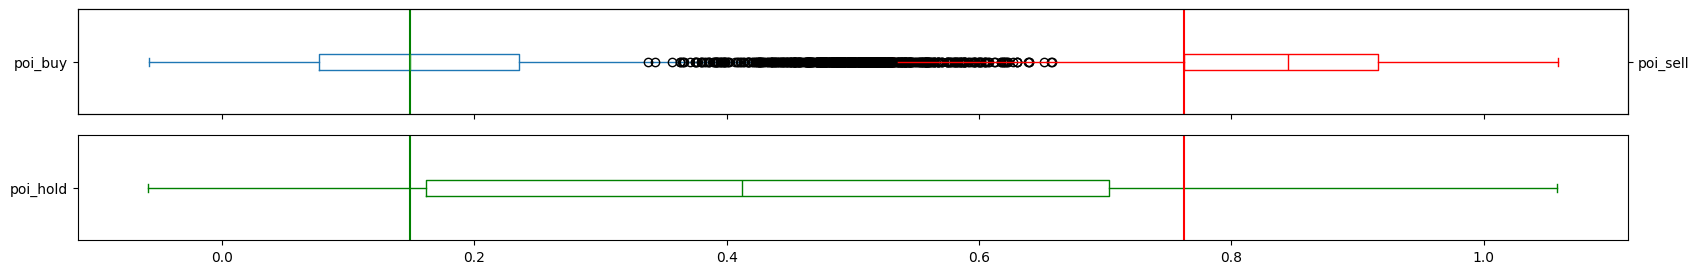

In [8]:
df, stock_code = df_map['NIFTY'], 'NIFTY'

dfs = []
initial_cash = df.high.max() * 5
for _, group in tqdm(df.groupby('date'), desc=stock_code):
    group['scaled_close'] = scale_by_bb(group.close, 2, 6)
    start_index = group.index[-1].replace(hour=9, minute=30)
    end_index = group.index[-1].replace(hour=15, minute=15)
    group = group[start_index:end_index].copy()

    dfs.append(
        mark_events(
            group,
            ref_frame=4
        )
    )

df = pd.concat(dfs)
df.drop(columns=['only_date'], inplace=True)
df.date = pd.to_datetime(df.date)
df['day_of_week'] = df.date.dt.day_of_week

df['poi_buy'] = (df.scaled_close * df.buy).dropna()
df['poi_sell'] = (df.scaled_close * df.sell).dropna()

df['poi_hold'] = df.scaled_close * (~(df['poi_buy'].astype(bool).fillna(
    False) & df['poi_sell'].fillna(False).astype(bool))).astype(int)
buy_threshold = df['poi_buy'].quantile(BUY_QUANTILE)
sell_threshold = df['poi_sell'].quantile(SELL_QUANTILE)

BUY_QUANTILE = .5
SELL_QUANTILE = .25

fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 3), sharex=True)
df['poi_buy'].plot.box(vert=False, ax=ax)
df['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
df['poi_hold'].plot.box(vert=False, ax=hax, color='g')

buy_threshold = df['poi_buy'].quantile(BUY_QUANTILE)
sell_threshold = df['poi_sell'].quantile(SELL_QUANTILE)

# df['poi_hold'].plot.box(vert=False, ax=ax.twinx().twinx(), color='r')
ax.axvline(buy_threshold, color='g')
hax.axvline(buy_threshold, color='g')
ax.axvline(sell_threshold, color='r')
hax.axvline(sell_threshold, color='r')

In [9]:
metrics = []

for stock_code in tqdm(df_map):
    try:
        metric = evaluate_metrics(
            stock_code,
            df_map[stock_code],
            deviation=DEVIATION,
            timeperiod=6,
            ref_frame=4
        )
        metrics.append(
            metric
        )
        pd.DataFrame(metrics).to_csv('metrics_6_4.csv', index=False)
    except Exception as e:
        print(e)
        pass

100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


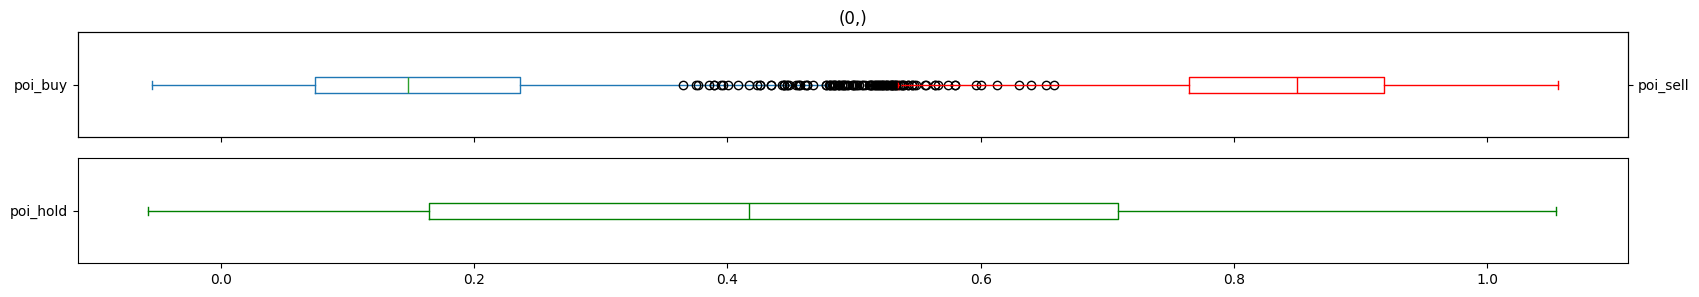

(0,)        poi_buy  poi_sell  poi_hold
0.05 -0.006672  0.556924  0.000000
0.50  0.147533  0.849725  0.417351
0.95  0.461697  0.999729  0.925730



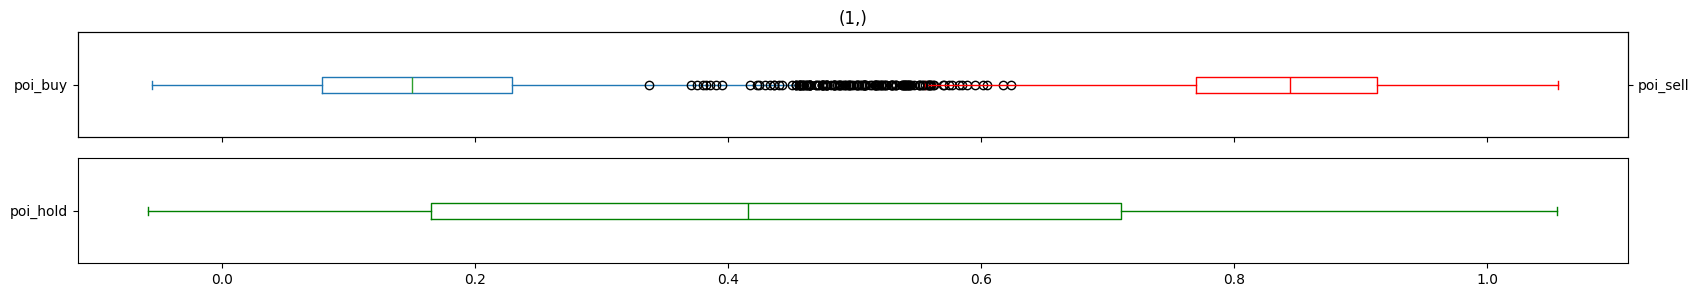

(1,)        poi_buy  poi_sell  poi_hold
0.05 -0.004286  0.542995  0.000000
0.50  0.149833  0.844223  0.415636
0.95  0.471392  0.998663  0.926464



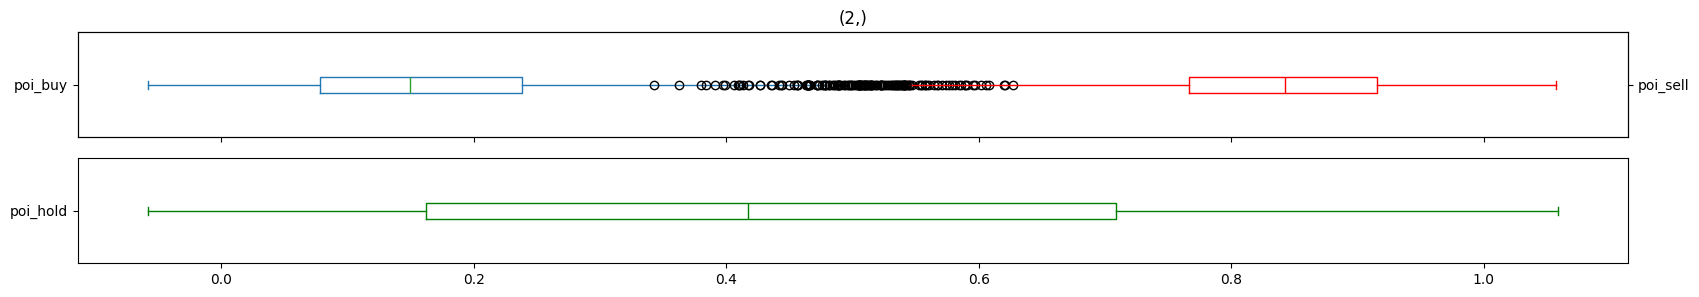

(2,)        poi_buy  poi_sell  poi_hold
0.05 -0.007566  0.527172  0.000000
0.50  0.149962   0.84273  0.416935
0.95  0.469262  1.003449  0.926306



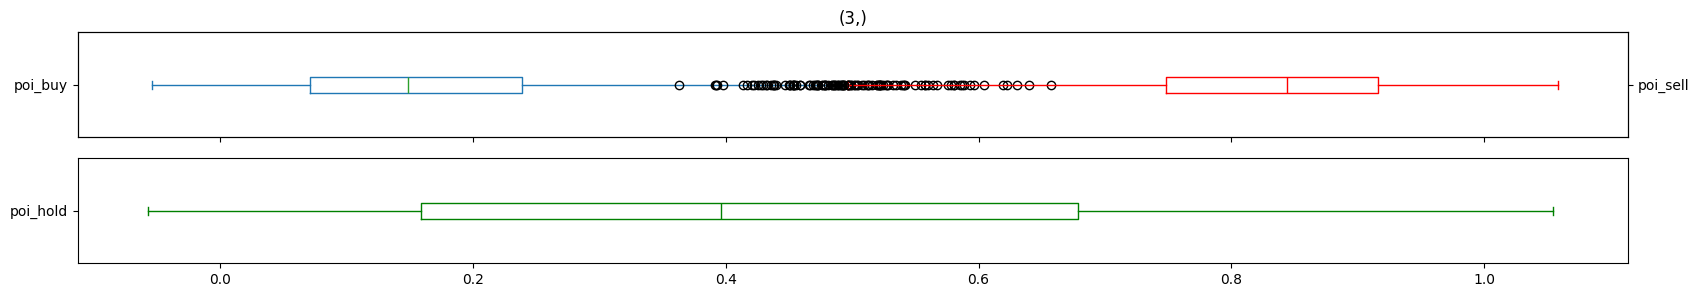

(3,)        poi_buy  poi_sell  poi_hold
0.05  -0.00654  0.520332  0.000000
0.50   0.14835  0.844088  0.396486
0.95  0.468364  0.999859  0.923746



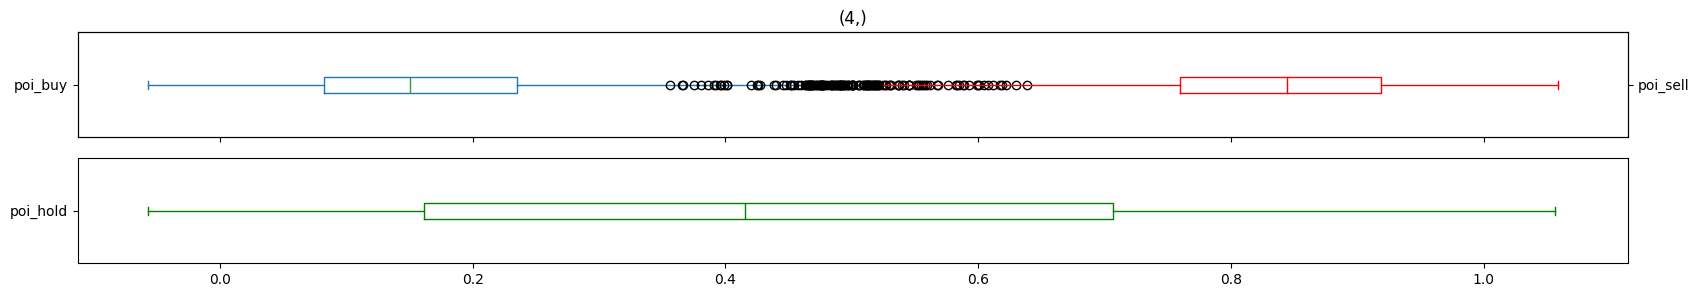

(4,)        poi_buy  poi_sell  poi_hold
0.05 -0.003577  0.531755  0.000000
0.50  0.150691  0.843988  0.415679
0.95  0.480302  1.012422  0.929572



In [10]:

for day, group in df.groupby(['day_of_week']):
    fig, (ax, hax) = plt.subplots(2, 1, figsize=(20, 3), sharex=True)
    group['poi_buy'].plot.box(vert=False, ax=ax)
    group['poi_sell'].plot.box(vert=False, ax=ax.twinx(), color='r')
    group['poi_hold'].plot.box(vert=False, ax=hax, color='g')
    ax.set_title(day)
    plt.show()
    plt.close()

    print(day, group[['poi_buy', 'poi_sell', 'poi_hold']
                     ].quantile([.05, .5, .95]))
    print()